In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
sns.set_theme()
warnings.filterwarnings("ignore")

### Read the Data

In [4]:
# First load the dataset
data = pd.read_excel("titanic3.xls")
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### When we try to understand the types of data in the dataset here are the following conclusions we can make
* The categorical columns are pclass,survived,sex,cabin,embarked
* Discreet columns sibsp,parch (sisb : Number of siblings parch: number of parent or children  aboard titanic)
* The continuous columns are age,body,fare
* columns boat,cabin,body have a lot of null values nearly 70% of the data is null so imputation may lead to bad results. 


In [5]:
# lets understand the types of data in the dataset
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


### In this task lets try to predict if a person will survive or not based on the other features. So our target columns is Survived. It is binary classification task


In [6]:
# For this task let our features be pclass,sex,age,fare

data_select = data[["pclass","sex","age","fare","sibsp","parch","survived"]]


### Null Value Imputation

In [7]:
# This line calculates the total number of missing (null) values in each column of the 'data_select' DataFrame
# and returns a series with the column names and their corresponding missing value counts.
data_select.isnull().sum()

pclass        0
sex           0
age         263
fare          1
sibsp         0
parch         0
survived      0
dtype: int64

In [8]:
# We see that there is only 1 null value in the 'fare' column. 
# This missing value can be filled by imputing it with the mean fare value of the class the passenger belongs to.

# Step 1: Identify the passenger class (pclass) of the row where 'fare' is missing
pclass = data_select[data_select["fare"].isnull()].iloc[0]["pclass"]

# Step 2: Get the row index of the missing fare value, which we will use to fill in the imputed value
index = data_select[data_select["fare"].isnull()].index[0]

# Step 3: Calculate the mean fare for the identified passenger class (pclass)
mean_pclass = data_select[data_select["pclass"] == pclass]["fare"].mean()

# Step 4: Print a message with the calculated mean value, which will be used to fill the missing fare value
print(f"We can impute the missing fare with the mean fare of the passenger class the particular passenger belongs to. The mean value is {mean_pclass}")

# Step 5: Assign the calculated mean fare value to the missing 'fare' cell, rounded to three decimal places for consistency
data_select.at[index, "fare"] = np.round(mean_pclass, 3)


We can impute the missing fare with the mean fare of the passenger class the particular passenger belongs to. The mean value is 13.302888700564973


<Axes: xlabel='age', ylabel='Density'>

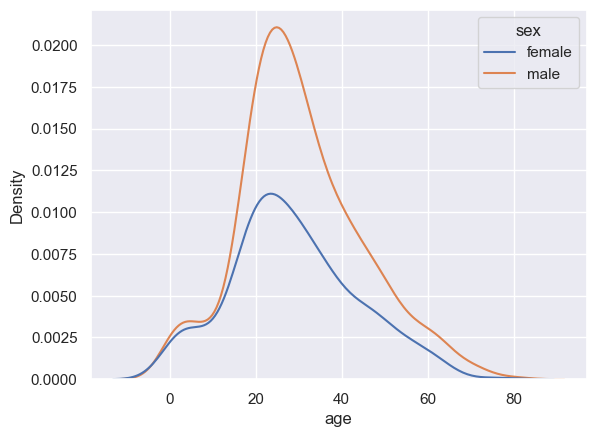

In [9]:
# The Age has 263 missing values. It is better to impute the age based on gender. As they have different distributions
# This line creates a Kernel Density Estimate (KDE) plot of the 'age' distribution in the 'data_select' DataFrame,
# separated by the 'sex' category, using Seaborn's kdeplot function.
# - 'data_select' specifies the DataFrame to use for the plot.
# - 'x="age"' sets the 'age' column as the variable for the x-axis, representing age distribution.
# - 'hue="sex"' colors the KDE plots by the 'sex' column, allowing comparison between male and female age distributions.
sns.kdeplot(data_select, x="age", hue="sex")


In [10]:
# Here we impute (fill) null values in the 'age' column based on the mean age for each gender.
# We do this separately for males and females to maintain demographic-specific averages.

# Step 1: For rows where 'age' is null and 'sex' is female:
# - Locate these rows in the 'data_select' DataFrame by using 'loc' and applying a conditional filter.
# - The condition filters rows where 'age' is null and 'sex' is "female".
# - We then fill the missing 'age' values for these rows with the mean age of all females in the dataset.
data_select.loc[data_select[(data_select["age"].isnull()) & (data_select["sex"] == "female")].index, "age"] = data_select[data_select["sex"] == "female"]["age"].mean()

# Step 2: Similarly, for rows where 'age' is null and 'sex' is male:
# - Use 'loc' to target rows with a null 'age' value and where 'sex' is "male".
# - Fill these missing 'age' values with the mean age of all males in the dataset.
data_select.loc[data_select[(data_select["age"].isnull()) & (data_select["sex"] == "male")].index, "age"] = data_select[data_select["sex"] == "male"]["age"].mean()


### Lets create different versions of the Dataset where we fill the Null values with an Invalid value say -1 , Random numbers sampled from the not null values , Global Mean , drop all NAs

In [11]:
# First with invalid values
data_select_with_invalid_value = data[["pclass","sex","age","fare","sibsp","parch","survived"]]
data_select_with_invalid_value.loc[(data_select_with_invalid_value["age"].isnull()),"age"] = -1
data_select_with_invalid_value.loc[(data_select_with_invalid_value["fare"].isnull()),"fare"] = -1

# Global mean
data_select_with_global_mean = data[["pclass","sex","age","fare","sibsp","parch","survived"]]
data_select_with_global_mean.loc[(data_select_with_global_mean["age"].isnull()),"age"] = data_select_with_global_mean["age"].mean()
data_select_with_global_mean.loc[(data_select_with_global_mean["fare"].isnull()),"fare"] = data_select_with_global_mean["fare"].mean()

# Random Values from the columns
data_select_with_random_samples = data[["pclass","sex","age","fare","sibsp","parch","survived"]]

# Not null values in the dataset
notnullages = data_select_with_random_samples[~data_select_with_random_samples["age"].isnull()]["age"]
notnullfares = data_select_with_random_samples[~data_select_with_random_samples["fare"].isnull()]["fare"]

data_select_with_random_samples.loc[(data_select_with_random_samples["age"].isnull()),"age"] = np.random.choice(notnullages,data_select_with_random_samples["age"].isnull().sum())
data_select_with_random_samples.loc[(data_select_with_random_samples["fare"].isnull()),"fare"] = np.random.choice(notnullfares,data_select_with_random_samples["fare"].isnull().sum())


# Finally we drop all Null values too

data_dropped_na = data.copy()[data_select.columns]
data_dropped_na.dropna(inplace=True)


### Now that our dataset has no missing values lets visualise some data

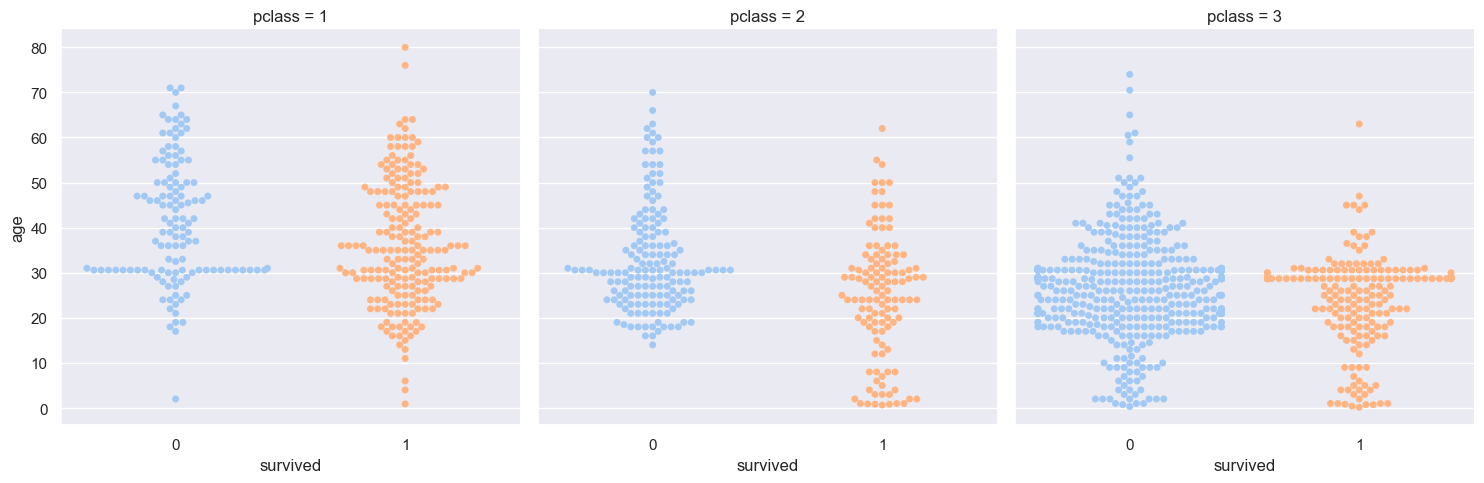

In [12]:
# This plot shows the distribution of passenger age  based on who survived or not

# This line creates a categorical (cat) plot to visualize the relationship between survival status and age, 
# separated by passenger class (pclass), using a swarm plot layout.
# 
# - 'x="survived"' sets the 'survived' column on the x-axis, showing survival status (0 for not survived, 1 for survived).
# - 'y="age"' sets the 'age' column on the y-axis, plotting passenger ages for each survival status.
# - 'col="pclass"' creates separate plots (facets) for each unique value in the 'pclass' column (passenger class),
#    showing different plots for each class (e.g., first, second, and third class).
# - 'data=data_select' specifies that the data to be plotted is from the 'data_select' DataFrame.
# - 'kind="swarm"' chooses a swarm plot, which displays each data point as an individual marker on the plot.
#    Swarm plots are useful for showing the distribution and density of individual data points without overlap.
# - 'palette="pastel"' applies a pastel color palette to make the plot visually distinct and clear.
sns.catplot(x="survived", y="age", col="pclass", data=data_select, kind="swarm", palette="pastel")


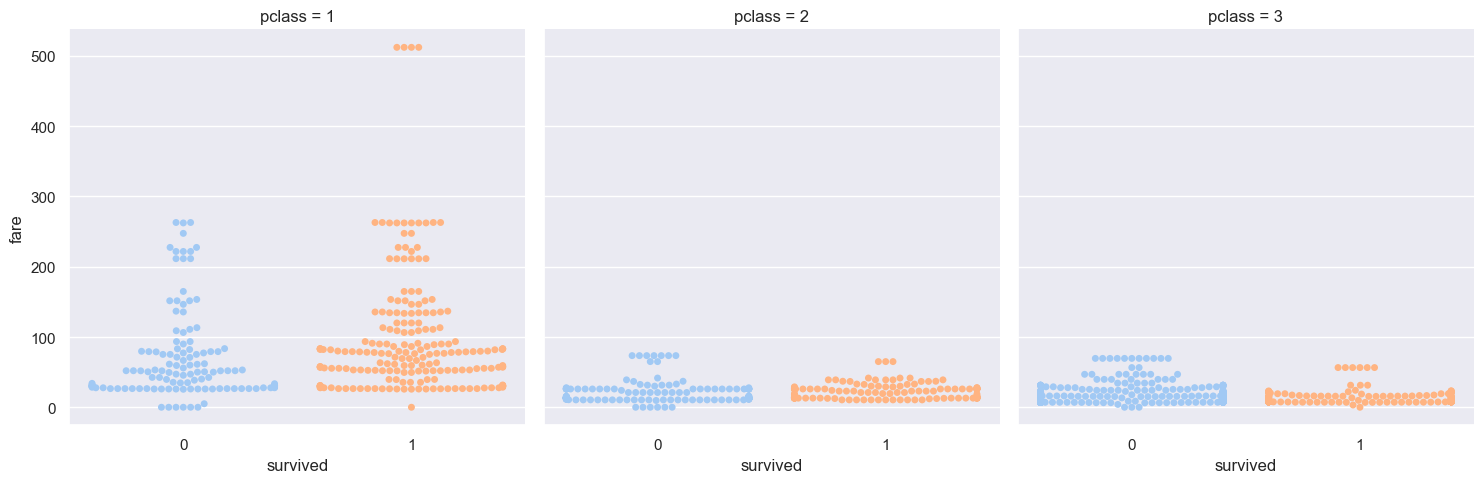

In [13]:
# This plot shows the distribution of passenger fare  based on who survived or not
# Interestingly the fare range is simlar for class 2 and 3 but highly variable in class 1. Particularly for the Survivors

# This line creates a categorical plot to examine the relationship between survival status and fare amount,
# separated by passenger class (pclass), using a swarm plot layout.
#
# - 'x="survived"' sets the 'survived' column on the x-axis, indicating survival status (0 for not survived, 1 for survived).
# - 'y="fare"' sets the 'fare' column on the y-axis, showing the fare amount for each survival status.
# - 'col="pclass"' creates separate plots (facets) for each unique value in the 'pclass' column (passenger class),
#    resulting in different plots for each class (e.g., first, second, and third class).
# - 'data=data_select' specifies that the plot will use data from the 'data_select' DataFrame.
# - 'kind="swarm"' selects a swarm plot type, which shows each fare as an individual data point on the plot,
#    helping to visualize the distribution of fare values without overlapping points.
# - 'palette="pastel"' applies a pastel color scheme for a visually clear and gentle color distinction.
sns.catplot(x="survived", y="fare", col="pclass", data=data_select, kind="swarm", palette="pastel")


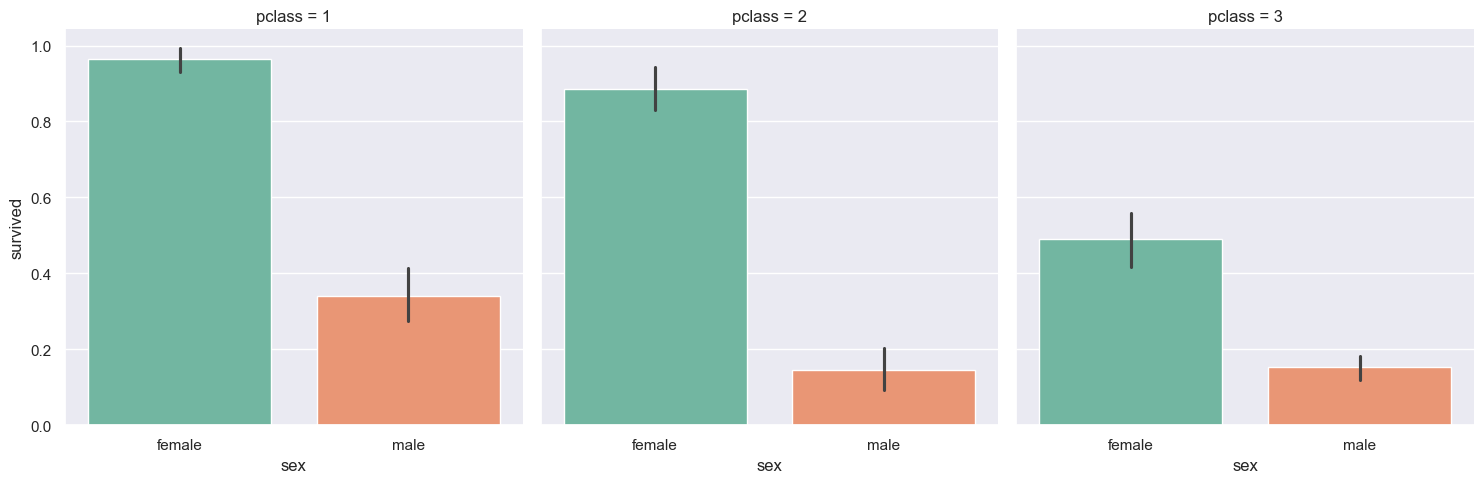

In [14]:
# In all classes larger proportion of females survived
sns.catplot(x="sex", y="survived", col="pclass", data=data_select, kind="bar",palette="Set2")

### Now that we have seen how some of our data look like lets use SVM and train a model on it

In [15]:
# Before we start dividing our data into train test split. Our variable named sex is of string type, we need to convert it to categorical
data_select.loc[data_select["sex"]=="male","sex"] = 1
data_select.loc[data_select["sex"]=="female","sex"] = 0

# Repeat it for the various versions of the 
data_select_with_invalid_value.loc[data_select_with_invalid_value["sex"]=="male","sex"] = 1
data_select_with_invalid_value.loc[data_select_with_invalid_value["sex"]=="female","sex"] = 0

data_select_with_random_samples.loc[data_select_with_random_samples["sex"]=="male","sex"] = 1
data_select_with_random_samples.loc[data_select_with_random_samples["sex"]=="female","sex"] = 0


data_select_with_global_mean.loc[data_select_with_global_mean["sex"]=="male","sex"] = 1
data_select_with_global_mean.loc[data_select_with_global_mean["sex"]=="female","sex"] = 0

data_dropped_na.loc[data_dropped_na["sex"]=="male","sex"] = 1
data_dropped_na.loc[data_dropped_na["sex"]=="female","sex"] = 0



In [16]:
# Now we can split all our datasets into train test splits. Note the random seed is kept same to ensure reporducibility
column_names = list(data_select.columns)
column_names.remove("survived")

X_train, X_test, y_train, y_test = train_test_split(data_select[column_names].to_numpy(),data_select["survived"].to_numpy(),test_size=0.3,random_state=5)

X_train_invalid_value, X_test_invalid_value, y_train_invalid_value, y_test_invalid_value = train_test_split(data_select_with_invalid_value[column_names].to_numpy(),data_select_with_invalid_value["survived"].to_numpy(),test_size=0.3,random_state=5)

X_train_random_samples, X_test_random_samples, y_train_random_samples, y_test_random_samples = train_test_split(data_select_with_random_samples[column_names].to_numpy(),data_select_with_random_samples["survived"].to_numpy(),test_size=0.3,random_state=5)

X_train_global_mean, X_test_global_mean, y_train_global_mean, y_test_global_mean = train_test_split(data_select_with_global_mean[column_names].to_numpy(),data_select_with_global_mean["survived"].to_numpy(),test_size=0.3,random_state=5)

X_train_drop_na, X_test_drop_na, y_train_drop_na, y_test_drop_na = train_test_split(data_dropped_na[column_names].to_numpy(),data_dropped_na["survived"].to_numpy(),test_size=0.3,random_state=5)

### Lets First try SVM Clssifier with Linear Kernel on all our datasets

In [17]:

# Utility function for metrics
def get_metrics(X,y,clf):
    print(f"model accuracy : {accuracy_score(y,clf.predict(X))}")
    print(classification_report(y,clf.predict(X)))
    cm = confusion_matrix(y,clf.predict(X))
    ConfusionMatrixDisplay.from_estimator(clf,X,y,cmap="Reds")

# Utility function for plotting feature importances (use this only for SVM with Linear Kernel)
def f_importances(classifier, names):

    coef = abs(classifier.coef_[0])
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

# Utility function for plotting feature importances (use this only for SVM with RBF Kernel)
def f_importances_RBF(classifier,names,X_test,y_test):
    features = np.array(names)
    perm_importance = permutation_importance(classifier, X_test, y_test)
    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")

model accuracy : 0.7557251908396947
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       246
           1       0.67      0.67      0.67       147

    accuracy                           0.76       393
   macro avg       0.74      0.74      0.74       393
weighted avg       0.76      0.76      0.76       393



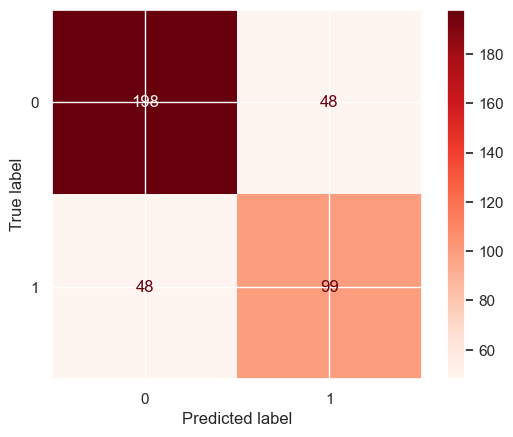

In [18]:
clf_linear = SVC(kernel="linear").fit(X_train,y_train)
get_metrics(X_test,y_test,clf_linear)


model accuracy : 0.7557251908396947
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       246
           1       0.67      0.67      0.67       147

    accuracy                           0.76       393
   macro avg       0.74      0.74      0.74       393
weighted avg       0.76      0.76      0.76       393



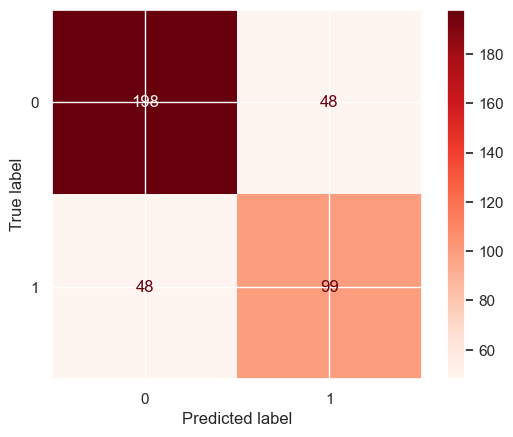

In [19]:
clf_linear_1 = SVC(kernel="linear").fit(X_train_invalid_value,y_train_invalid_value)
get_metrics(X_test_invalid_value,y_test_invalid_value,clf_linear_1)

model accuracy : 0.7557251908396947
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       246
           1       0.67      0.67      0.67       147

    accuracy                           0.76       393
   macro avg       0.74      0.74      0.74       393
weighted avg       0.76      0.76      0.76       393



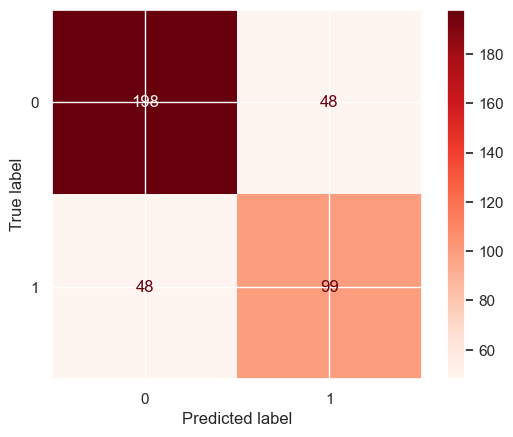

In [20]:
clf_linear_2 = SVC(kernel="linear").fit(X_train_random_samples,y_train_random_samples)
get_metrics(X_test_random_samples,y_test_random_samples,clf_linear_2)

model accuracy : 0.7802547770700637
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       206
           1       0.68      0.69      0.68       108

    accuracy                           0.78       314
   macro avg       0.76      0.76      0.76       314
weighted avg       0.78      0.78      0.78       314



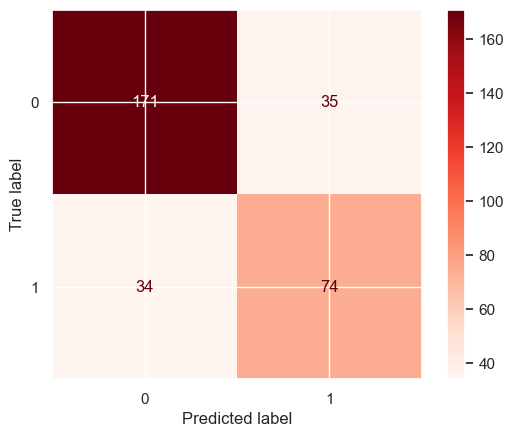

In [21]:
clf_linear_3 = SVC(kernel="linear").fit(X_train_drop_na,y_train_drop_na)
get_metrics(X_test_drop_na,y_test_drop_na,clf_linear_3)

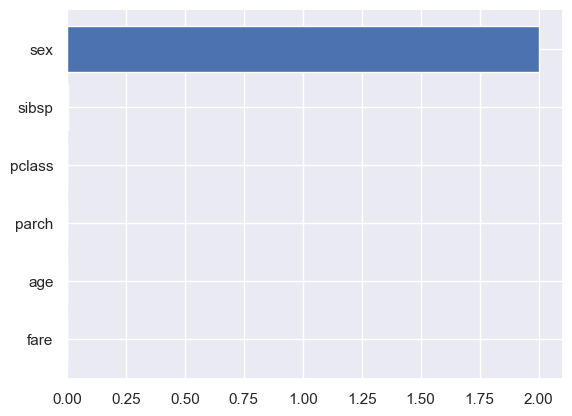

In [22]:
# Lets check the feature importances
feature_names = column_names
f_importances(clf_linear,feature_names)

### Lets First try SVM Clssifier with Linear RBF (Non Linear Kernel)

model accuracy : 0.6590330788804071


              precision    recall  f1-score   support

           0       0.67      0.91      0.77       246
           1       0.61      0.24      0.34       147

    accuracy                           0.66       393
   macro avg       0.64      0.57      0.56       393
weighted avg       0.65      0.66      0.61       393



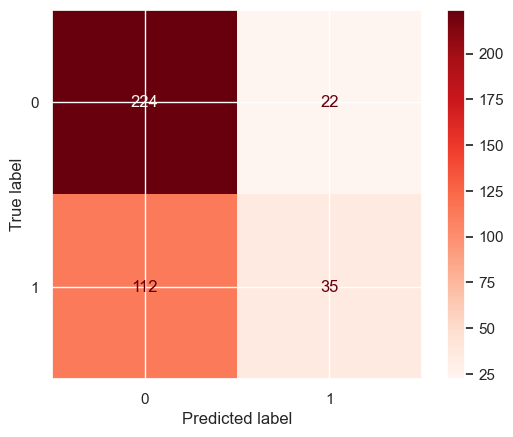

In [23]:
clf_rbf = SVC(kernel="rbf").fit(X_train,y_train)
get_metrics(X_test,y_test,clf_rbf)

model accuracy : 0.6615776081424937
              precision    recall  f1-score   support

           0       0.67      0.91      0.77       246
           1       0.62      0.24      0.34       147

    accuracy                           0.66       393
   macro avg       0.65      0.58      0.56       393
weighted avg       0.65      0.66      0.61       393



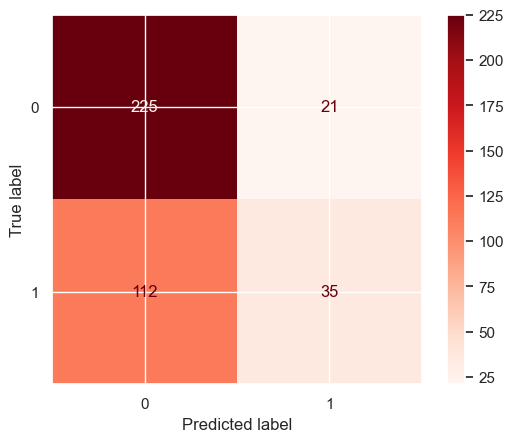

In [24]:
clf_rbf_1 = SVC(kernel="rbf").fit(X_train_random_samples,y_train_random_samples)
get_metrics(X_test_random_samples,y_test_random_samples,clf_rbf_1)

model accuracy : 0.6564885496183206
              precision    recall  f1-score   support

           0       0.66      0.91      0.77       246
           1       0.61      0.23      0.33       147

    accuracy                           0.66       393
   macro avg       0.64      0.57      0.55       393
weighted avg       0.64      0.66      0.61       393



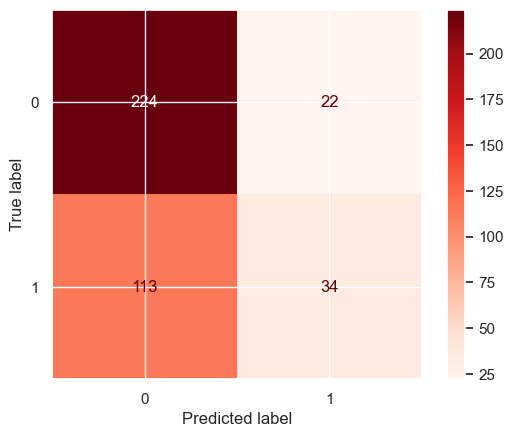

In [25]:
clf_rbf_2 = SVC(kernel="rbf").fit(X_train_global_mean,y_train_global_mean)
get_metrics(X_test_global_mean,y_test_global_mean,clf_rbf_2)

model accuracy : 0.6615776081424937
              precision    recall  f1-score   support

           0       0.67      0.92      0.77       246
           1       0.63      0.22      0.33       147

    accuracy                           0.66       393
   macro avg       0.65      0.57      0.55       393
weighted avg       0.65      0.66      0.61       393



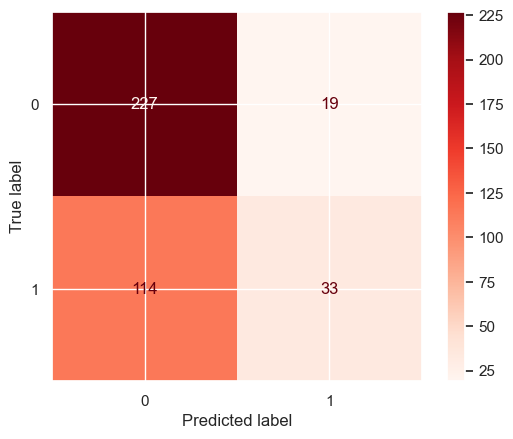

In [26]:
clf_rbf_3 = SVC(kernel="rbf").fit(X_train_invalid_value,y_train_invalid_value)
get_metrics(X_test_invalid_value,y_test_invalid_value,clf_rbf_3)

model accuracy : 0.6719745222929936
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       206
           1       0.54      0.33      0.41       108

    accuracy                           0.67       314
   macro avg       0.62      0.59      0.59       314
weighted avg       0.65      0.67      0.65       314



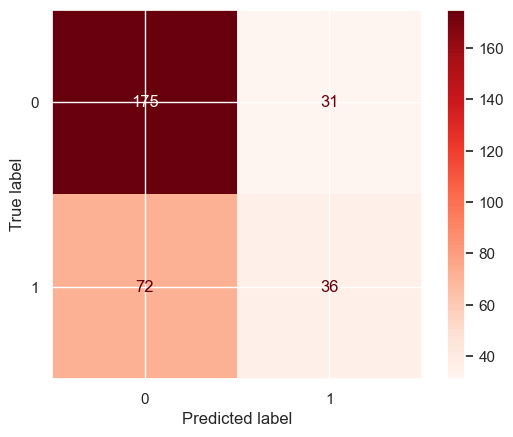

In [27]:
clf_rbf_4 = SVC(kernel="rbf").fit(X_train_drop_na,y_train_drop_na)
get_metrics(X_test_drop_na,y_test_drop_na,clf_rbf_4)

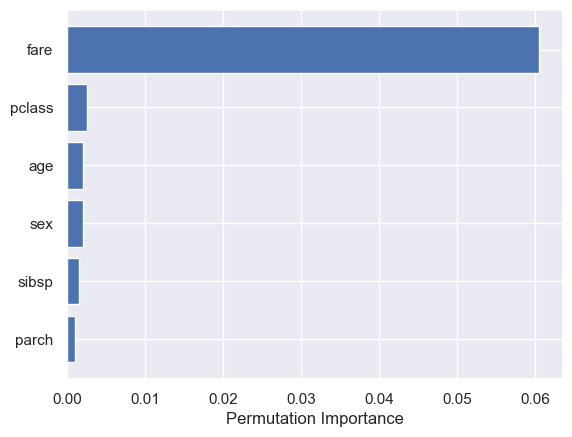

In [28]:
# Feature importances for RBF Kernel
features = np.array(column_names)
f_importances_RBF(clf_rbf,features,X_test,y_test)